# Feasibility Model Training and Evaluation

This notebook performs the training, hyperparameter optimization, and evaluation of the feasibility neural network model for predicting the most comparison-efficient sorting algorithm.

The **input file** is `trainingDataMax.csv` (containing presortedness features and labels).

To investigate the different research questions, chose the corresponding features for `X` (see TrainingSetCreation200)

## Setup

In [1]:
import os
import scipy
import pandas as pd
import numpy as np
import math
import random
import matplotlib.pyplot as plt
np.random.seed(42)
random.seed(42)

os.getcwd()

dataset_directory = './kaggledatasets'
dataset_dfs = {}

## Neural network model

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid

from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier

df_results = pd.read_csv('trainingData.csv')

tf.random.set_seed(42)

# Presortedness metrics for full array: 'Inversions', 'Deletions', 'Runs', 'Dis'
# Presortedness metrics for sample_size = 10 distributed sampling: 'Inversions_dist', 'Deletions_dist', 'Runs_dist', 'Dis_dist'
X = df_results[['Inversions', 'Deletions', 'Runs', 'Dis']]

y = df_results['Algorithm']

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# This split has been used to optimize a few parameters, can't be used to calculate final accuracy:
# X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

X_train, X_split, y_train, y_split = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_split, y_split, test_size=0.5, random_state=42)

train_indices = X_train.index
test_indices = X_test.index

#index split insight
#print(train_indices,test_indices)

# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

# neural network

def create_model(layers, layersize):
    model = Sequential()
    model.add(Dense(layersize, input_dim=4, activation='relu'))
    for i in range(layers):
        model.add(Dense(layersize, activation='relu'))
        
    model.add(Dense(len(label_encoder.classes_), activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])
    return model


param_grid = {
    'batch_size': [512],
    'epochs': [500],
    'layers': [0,1,2,3,4,5,6,7,8,9],
    'layersize': [1,2,3,4,5,6,7,8,9,10]
}

# Best: Layers  Layer Size  Accuracy
#67       6           8  0.840237
#33       3           4  0.840237
#35       3           6  0.840237

best_accuracy = 0
best_params = None

grid_results = []

for params in ParameterGrid(param_grid):
    print("Training model with params:", params)
    model = create_model(layers = params['layers'], layersize = params['layersize'])
    model.fit(X_train_scaled, y_train, batch_size=params['batch_size'], epochs=params['epochs'], verbose=0)
    y_pred = model.predict(X_val_scaled)
    accuracy = model.evaluate(X_val_scaled, y_val, verbose=0)[1]
    grid_results.append({
        'Layers': params['layers'],
        'Layer Size': params['layersize'],
        'Accuracy': accuracy
    })
    print("Accuracy:", accuracy)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = params
        best_model = model

df_grid_results = pd.DataFrame(grid_results)

print("Best validation parameters:", best_params)
print("Best validation accuracy:", best_accuracy)
print("\n")

y_pred = best_model.predict(X_test_scaled)
baccuracy = best_model.evaluate(X_test_scaled, y_test, verbose=0)[1]
print("Test Accuracy:", baccuracy)

Training model with params: {'batch_size': 512, 'epochs': 500, 'layers': 0, 'layersize': 1}


c:\Python311\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Accuracy: 0.6804733872413635
Training model with params: {'batch_size': 512, 'epochs': 500, 'layers': 0, 'layersize': 2}
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Accuracy: 0.8224852085113525
Training model with params: {'batch_size': 512, 'epochs': 500, 'layers': 0, 'layersize': 3}
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Accuracy: 0.834319531917572
Training model with params: {'batch_size': 512, 'epochs': 500, 'layers': 0, 'layersize': 4}
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Accuracy: 0.834319531917572
Training model with params: {'batch_size': 512, 'epochs': 500, 'layers': 0, 'layersize': 5}
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Accuracy: 0.834319531917572
Training model with params: {'batch_size': 512, 'epochs': 500, 'layers': 0, 'layersize': 6}
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Accuracy: 0.8284023404121399
Training model with params: {'batch_size': 512, 'epochs': 500, 'layers': 0, 'layersize': 7}
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/ste

In [3]:
import pickle

# Save the dictionary to a file
with open('df_grid_results_fullArray.pkl', 'wb') as f:
    pickle.dump(df_grid_results, f)

---

## Algorithm Prediction Summary

This section compares the **actual vs. predicted counts** for each sorting algorithm in the test set and reports the number of **true positives** per class.

---


In [6]:
y_pred = best_model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred, axis=1)
predicted_algorithms = label_encoder.inverse_transform(y_pred_classes)
true_algorithms = label_encoder.inverse_transform(y_test)
comparison_df = pd.DataFrame({'Predicted Algorithm': predicted_algorithms, 'True Algorithm': true_algorithms})

accuracy = best_model.evaluate(X_test_scaled, y_test, verbose=0)[1]
print("Test Accuracy:", baccuracy)

actual_counts = comparison_df["True Algorithm"].value_counts()
predicted_counts = comparison_df["Predicted Algorithm"].value_counts()

summary_table = pd.DataFrame({
    "Actual Count": actual_counts,
    "Predicted Count": predicted_counts
})

print(summary_table)
correct_merge_count = ((comparison_df["True Algorithm"] == "merge_sort") & (comparison_df["Predicted Algorithm"] == "merge_sort")).sum()
correct_timsort_count = ((comparison_df["True Algorithm"] == "timsort") & (comparison_df["Predicted Algorithm"] == "timsort")).sum()
correct_insertion_count = ((comparison_df["True Algorithm"] == "insertion_sort") & (comparison_df["Predicted Algorithm"] == "insertion_sort")).sum()
correct_quick_sort_count = ((comparison_df["True Algorithm"] == "quick_sort") & (comparison_df["Predicted Algorithm"] == "quick_sort")).sum()
correct_introsort_count = ((comparison_df["True Algorithm"] == "introsort") & (comparison_df["Predicted Algorithm"] == "introsort")).sum()

print("correctly predicted insertion_sort:", correct_insertion_count)
print("correctly predicted timsort:", correct_timsort_count)
print("correctly predicted merge_sort:", correct_merge_count)
print("correctly predicted quick_sort:", correct_quick_sort_count)
print("correctly predicted introsort:", correct_introsort_count)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step
Test Accuracy: 0.831360936164856
                Actual Count  Predicted Count
insertion_sort            68             70.0
introsort                 19              NaN
merge_sort               147            188.0
quick_sort                26              NaN
timsort                   78             80.0
correctly predicted insertion_sort: 68
correctly predicted timsort: 73
correctly predicted merge_sort: 140
correctly predicted quick_sort: 0
correctly predicted introsort: 0


---

## Average Comparisons Analysis

This section evaluates the **average number of comparisons** required by:

- The **minimum possible**, which represents the theoretical lower bound always choosing the most comparison efficient sorting algorithm
- The **prediction model**
- The classical sorting algorithms (Timsort, Merge Sort, Insertion Sort, Introsort, Quick Sort)

The results are visualized on a logarithmic scale to account for big differences in magnitude

---

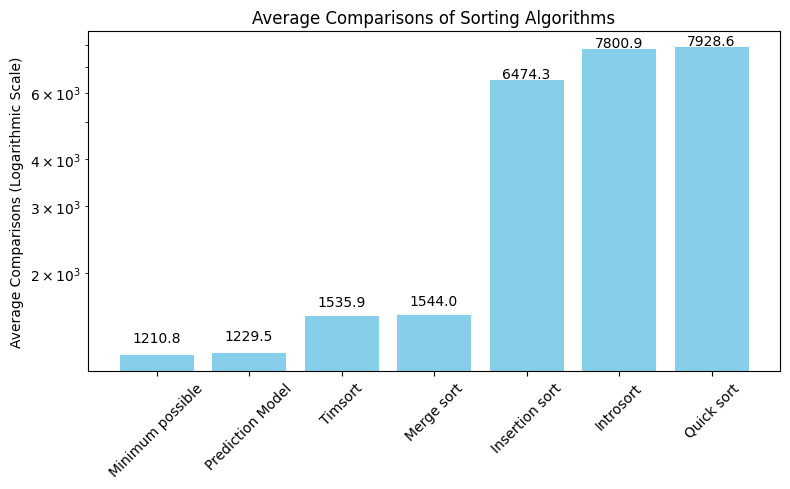

Minimum possible:  1210.8
Algorithm predicting model:  1229.5


Merge sort:  1544.0
Timsort:  1535.9
Introsort:  7800.9
Quick sort:  7928.6
Insertion sort:  6474.3
Selection sort:  19900.0


In [7]:
test_set_df = df_results.iloc[test_indices]
test_set_df.reset_index(drop=True, inplace=True)

c = []
t = []

for index, row in test_set_df.iterrows():
    c.append(row[predicted_algorithms[index]])
    t.append(row[true_algorithms[index]])

def calculate_average(column_name):
    return round(np.sum(test_set_df[column_name]) / len(test_set_df), 1)

minimum_possible = round(np.sum(t)/len(test_set_df), 1)
algorithm_prediction_model = round(np.sum(c)/len(test_set_df), 1)

merge_sort_avg = calculate_average('merge_sort')
timsort_avg = calculate_average('timsort')
introsort_avg = calculate_average('introsort')
quick_sort_avg = calculate_average('quick_sort')
insertion_sort_avg = calculate_average('insertion_sort')
selection_sort_avg = calculate_average('selection_sort')


data = {
    'Algorithm': ['Minimum possible', 'Prediction Model','Timsort', 'Merge sort', 'Insertion sort', 'Introsort', 'Quick sort'],
    'Average Value': [minimum_possible, round(algorithm_prediction_model, 1), timsort_avg, merge_sort_avg, insertion_sort_avg, introsort_avg, quick_sort_avg]
}
df_average_comp = pd.DataFrame(data)

# Plot
plt.figure(figsize=(8, 5))

plt.bar(df_average_comp['Algorithm'], df_average_comp['Average Value'], color='skyblue')

plt.title('Average Comparisons of Sorting Algorithms')

for i, val in enumerate(df_average_comp['Average Value']):
    plt.text(i, val + 100, str(val), ha='center')

plt.ylabel('Average Comparisons (Logarithmic Scale)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')
plt.yscale('log')
plt.tight_layout()
plt.savefig("full_performance.svg", format='svg')
plt.show()

print('Minimum possible: ', minimum_possible)
print('Algorithm predicting model: ', algorithm_prediction_model)
print('\n')
print('Merge sort: ', merge_sort_avg)
print('Timsort: ', timsort_avg)
print('Introsort: ', introsort_avg)
print('Quick sort: ', quick_sort_avg)
print('Insertion sort: ', insertion_sort_avg)
print('Selection sort: ', selection_sort_avg)